## Imports

In [1]:
import pickle
import pandas as pd
from preprocessing import *
from feature_extraction import *
from SVM_pipeline import SVM_Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Preprocessing
For data pre-processing, make sure datasets are extracted into the 'datasets' directory in the project root. The structure should be: \
`datasets/1 December 2017 Dataset/*.dat`

In [ ]:
dataset_dir = 'datasets'
datasets_batches = get_dataset_batches(dataset_dir)

spectrograms_MTI = []
labels = []

for batch in datasets_batches:
    files = get_dataset_files(dataset_dir, batch)
    for i, file in enumerate(files):
        if 'Copy' in file or '(' in file:
            print(f'{batch} | [{i + 1}/{len(files)}]: {file} ignored for unrecognized file name.')
            continue

        t = time.time()
        dataset_file_path = os.path.join(dataset_dir, batch, file)
        person, activity, repetition = get_labels(file)
        Data_spec_MTI, velocity_axis, time_axis = preprocess_file(dataset_file_path, th_type='triangle', plot_range_mti=False, plot_spec_mti=False)

        spectrograms_MTI.append((Data_spec_MTI, velocity_axis, time_axis))
        # Only interested in activity
        labels.append(activity)

        print(f'{batch} | [{i + 1}/{len(files)}]: {file} in {time.time() - t:.2f} seconds. Activity: {activity}.')

os.makedirs('preprocessed_data', exist_ok=True)
with open(os.path.join('preprocessed_data', 'spectrograms.pkl'), 'wb') as f:
    pickle.dump((spectrograms_MTI, np.array(labels)), f)

## Load pre-processed data
```
spectrograms_MTI:     list of (2D array, 1D array, 1D array)
labels:               1D array of integers
```

In [4]:
with open(os.path.join('preprocessed_data', 'spectrograms.pkl'), 'rb') as f:
    # Each item in spectrograms_MTI is (spec, velocity_axis, time_axis)
    denoised_spectrograms_MTI, labels = pickle.load(f)

    # Option 1: Extract into separate lists
    spectrograms = [i[0] for i in denoised_spectrograms_MTI]
    velocity_axes = [i[1] for i in denoised_spectrograms_MTI]
    time_axes = [i[2] for i in denoised_spectrograms_MTI]

In [ ]:
# Using per time-bin triangle thresholding denoise each spectrogram
for idx, (spectrogram, velocity_axis, time_axis) in enumerate(denoised_spectrograms_MTI):
    # Apply thresholding algorithm to spectrograms and update them in place
    spectrograms[idx][:] = denoise_spectrogram_per_timebin_basis(spectrogram)

## Feature extraction

Extract features from spectrograms and save the features to a file

In [22]:
features = []
for spectrogram, velocity_axis, time_axis, label in zip(spectrograms, velocity_axes, time_axes, labels):
    feature = feature_extraction(spectrogram, velocity_axis, time_axis)
    feature['label'] = label # Add label to the feature dictionary
    features.append(feature)

features_df = pd.DataFrame(features) # Save the features as a DataFrame
features_df.to_csv('preprocessed_data/features.csv', index=False)

If features.csv already exists, read the data from the "extracted_features/features.csv"

In [11]:
features_df = pd.read_csv('extracted_features/features.csv')
# Show one element from each different label
for label in features_df['label'].unique():
    print(features_df[features_df['label'] == label].head(1))

   normalized_std    period    offset  bandwidth  bandwidth_wo_uD  \
0        6.432582  0.007176  2.655047   6.336207         0.387931   

   torso frequency  label  
0         0.184541      1  
    normalized_std    period   offset  bandwidth  bandwidth_wo_uD  \
60       11.193546  0.008526  2.73954  17.715517         0.420259   

    torso frequency  label  
60        -0.096258      2  
     normalized_std    period    offset  bandwidth  bandwidth_wo_uD  \
120        8.308178  0.007233  2.298081   6.788793         0.064655   

     torso frequency  label  
120         0.056052      3  
     normalized_std    period    offset  bandwidth  bandwidth_wo_uD  \
180        7.271315  0.005587  1.619404   4.202586         0.452586   

     torso frequency  label  
180         0.016533      4  
     normalized_std   period    offset  bandwidth  bandwidth_wo_uD  \
240         7.29772  0.00655  1.613019   6.497845         0.484914   

     torso frequency  label  
240        -0.043686      5  
 

Visualize means and standard deviations of features after standardizing features per class basis

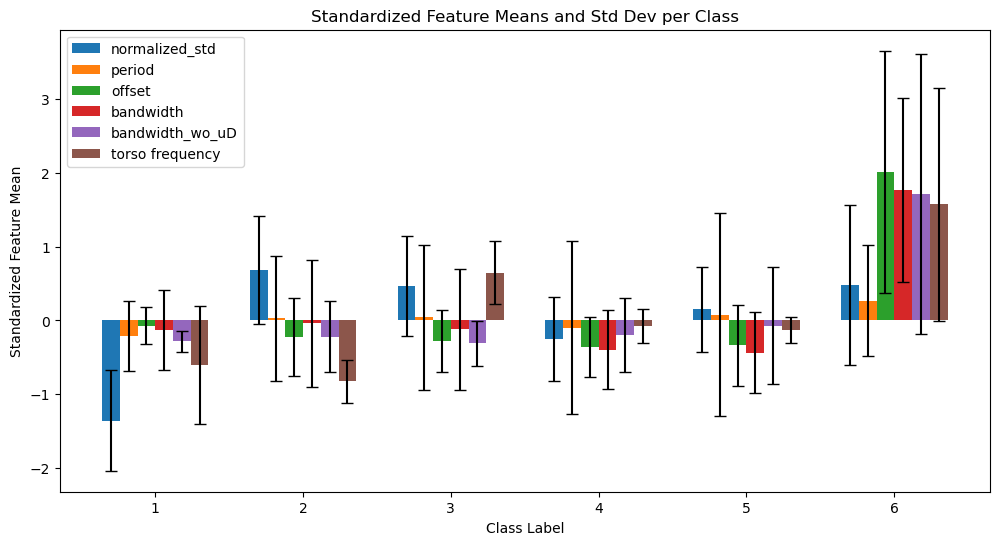

In [12]:
analyze_mean_and_std_of_features(features_df)

## Machine Learning Pipeline

Initialize pipeline and split data

In [14]:
random_state = 42                                                               # Repeatable random state for reproducibility
split_ratio = 0.2                                                               # Ratio of the dataset to be used for testing
n_splits = 5                                                                    # Number of splits for cross-validation
n_features = features_df.shape[1] - 1                                           # Number of features (exclude the label column from the feature count)
svm_pipeline = SVM_Pipeline(n_splits=n_splits, random_state=random_state)       # Instantiate the SVM pipeline

# Split the data into training and test sets
X_train, X_test, y_train, y_test = svm_pipeline.init_and_split_data(features_df, split_ratio=split_ratio, random_state=random_state)

# Define parameter search space for SVM hyperparameters
param_grid = [
    {
        'scaler': [StandardScaler(), MinMaxScaler(), None],
        'svm__kernel': ['linear', 'rbf', 'sigmoid'],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto']
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler(), None],
        'svm__kernel': ['poly'],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto'],
        'svm__degree': [2, 3, 4]  # Only relevant for poly kernel
    }
]
svm_pipeline.set_param_grid(param_grid) # Set the parameter grid for hyperparameter tuning

Run grid search over the hyperparameter grid.

(Since this can take around 20 minutes, you can load the best model instead and skip this part.)

In [5]:
svm_pipeline.run_grid_search(X_train, y_train, scoring="f1_macro") # Conduct hyperparameter tuning using grid search
svm_pipeline.save_best_model('best_svm_model.pkl') # Save the best model
svm_pipeline.show_grid_search_results()

,params,mean_test_score,std_test_score,rank_test_score
0,"{'scaler': StandardScaler(), 'svm__C': 10, 'sv...",0.796334,0.018076,1


If you have skipped the grid search, load the best model.

In [6]:
svm_pipeline.load_best_model('best_svm_model.pkl')

Run SFS to learn the importance of features.

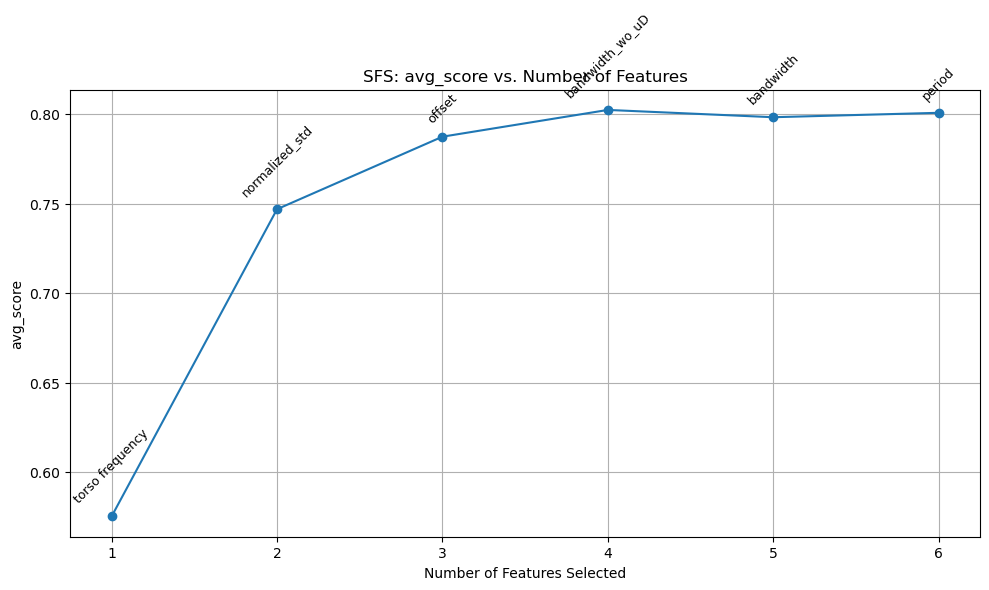

In [7]:
sfs = svm_pipeline.run_sfs_with_best_estimator(X_train, y_train, scoring='f1_macro', cv=n_splits)
svm_pipeline.plot_sfs_feature_importance(sfs=sfs, feature_names=features_df.columns[:-1].tolist())

Using the best model, build confusion matrix, compute relevant per class and average scores.

Best params: {'scaler': StandardScaler(), 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


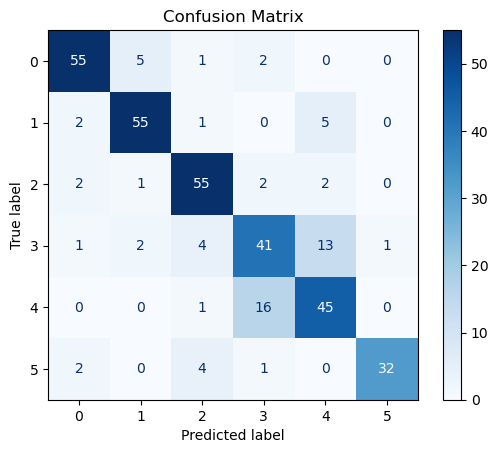

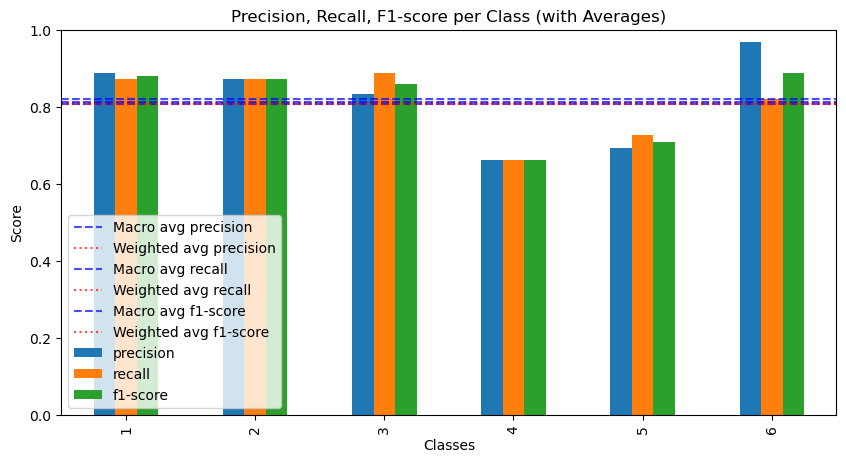

In [8]:
# Evaluate the best model on the test set
report = svm_pipeline.evaluate_model(X_test, y_test)

Plot learning curve to cheack overfitting or underfitting

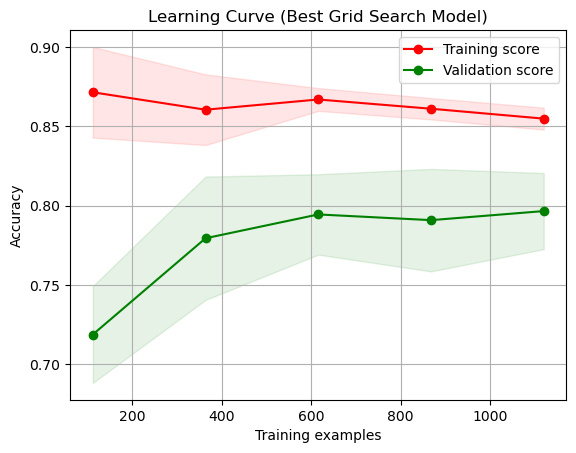

In [9]:
svm_pipeline.plot_learning_curve(X_train, y_train)

Check decision boundaries of the model.

We used PCA to project data points to 2D, then created a grid in 2D, inverse transformed the grid to n_features dimensions, predicted grid values to obtain boundaries. But the visualization does not look good.

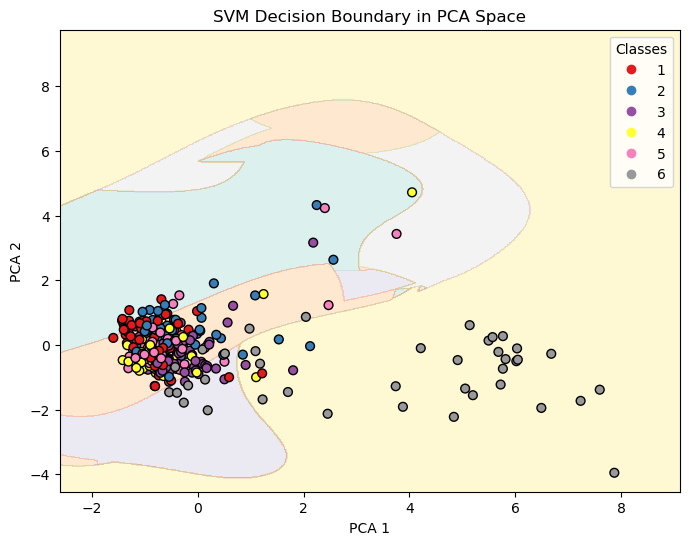

In [10]:
svm_pipeline.visualize_decision_boundaries_using_PCA(X_train, X_test, y_train, y_test)